In [1]:
import sys 
sys.path.append("../")

import itertools
import numpy as np
from pprint import pprint
from rl.returns import returns
import rl.markov_process as mp
import matplotlib.pyplot as plt 
from rl.distribution import Choose
from collections import defaultdict
from typing import Iterable, TypeVar, Dict, Mapping, Callable
from rl.approximate_dynamic_programming import ValueFunctionApprox
from rl.function_approx import Gradient, Tabular, learning_rate_schedule
from rl.chapter10.prediction_utils import fmrp_episodes_stream, unit_experiences_from_episodes


plt.rcParams['figure.figsize'] = (15, 7)

## Question 1: TD $(\lambda)$ algorithm from scratch:
### Part A - `Tabular` case

In [2]:
S = TypeVar("S")



def TabularTDLambdaPrediction(traces: Iterable[Iterable[mp.TransitionStep[S]]], vf : Mapping[S, float], gamma : float = 0.9,
                              lambd : float = 0.2, lr_f : Callable[[int], float] = learning_rate_schedule(0.01, 10000.0, 0.5)) -> Iterable[Mapping[S, float]]:
    counts : Dict[S, int] = defaultdict(lambda : int(1))
    nt_states = vf.keys()

    for n, trace in enumerate(traces):
        el_tr: Dict[S, float] = {s : 0.0 for s in nt_states}
        for step in trace:
            el_tr = {s : el_tr[s] * gamma * lambd + (1.0 if step.state == s else 0.0) for s in el_tr}
            td_error = step.reward + gamma * vf[step.next_state] - vf[step.state]
            vf = {s : vf[s] + lr_f(n) * td_error * el_tr[s] for s in nt_states}
            yield vf

## Question 4: testing out my implementations
### Exact solution for `SimpleInventoryMRPFinite`:

In [3]:
from rl.chapter2.simple_inventory_mrp import *

user_capacity = 2
user_poisson_lambda = 1.0
user_holding_cost = 1.0
user_stockout_cost = 10.0
user_gamma = 0.9

si_mrp = SimpleInventoryMRPFinite(capacity=user_capacity,
                                  poisson_lambda=user_poisson_lambda,
                                  holding_cost=user_holding_cost,
                                  stockout_cost=user_stockout_cost)

print("Exact Value Function:")
print("--" * 20)
si_mrp.display_value_function(gamma=user_gamma)
print()

Exact Value Function:
----------------------------------------
{NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.345,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.932,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.932,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.511,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.345,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.345}



### Tabular MC Prediction:

In [4]:
S = TypeVar("S")

def TabularMCPrediction(traces : Iterable[Iterable[mp.TransitionStep[S]]],
                        gamma : float = 0.9, episode_tol : float = 1e-6, num_traces : int = 1000) -> Mapping[S, float]:
    episodes : Iterator[ReturnStep[S]] = (returns(trace, gamma, episode_tol) for trace in traces)
    vf : Dict[S, float] = defaultdict(float)
    counts : Dict[S, int] = defaultdict(lambda : int(1))

    num_episodes = int(np.log(episode_tol) / np.log(gamma))

    for episode in itertools.islice(episodes, num_traces):
        for tr in itertools.islice(episode, num_episodes):
            vf[tr.state] += (tr.return_ - vf[tr.state]) / (counts[tr.state] + 1)
            counts[tr.state] += 1

    return vf






traces : Iterable[Iterable[mp.TransitionStep[InventoryState]]] = si_mrp.reward_traces(Choose(si_mrp.non_terminal_states))

mc_vf = TabularMCPrediction(traces=traces, gamma=user_gamma, episode_tol=1e-6, num_traces=1000)
print("Value Function from Tabular MC Prediction:")
print("--" * 20)
pprint({s : round(mc_vf[s], 3) for s in si_mrp.non_terminal_states})
print()

Value Function from Tabular MC Prediction:
----------------------------------------
{NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.21,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.819,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.888,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.398,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.193,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.292}



### Tabular TD Prediction:

In [5]:
def TabularTDPrediction(traces: Iterable[mp.TransitionStep[S]], vf : Mapping[S, float], gamma : float = 0.9,
                        lr_f : Callable[[int], float] = learning_rate_schedule(0.01, 10000.0, 0.5)) -> Mapping[S, float]:
    counts : Dict[S, int] = defaultdict(lambda : int(1))

    for n, tr in enumerate(traces):
        vf[tr.state] += lr_f(n) * (tr.reward + gamma * vf[tr.next_state] - vf[tr.state])
        counts[tr.state] += 1
    
    return vf





init_lr = 0.01
half_life = 1000
exp = 0.5

num_traces = 1000
num_episodes = 100

episodes : Iterable[Iterable[mp.TransitionStep[InventoryState]]] = si_mrp.reward_traces(Choose(si_mrp.non_terminal_states))
traces : Iterable[mp.TransitionStep[InventoryState]] = unit_experiences_from_episodes(episodes, num_episodes)
lr_f = learning_rate_schedule(init_lr, half_life, exp)

td_vf = TabularTDPrediction(traces=itertools.islice(traces, num_episodes * num_traces), gamma=user_gamma, vf={s : 0.0 for s in si_mrp.non_terminal_states}, lr_f = lr_f)
print("Value Function from Tabular TD Prediction:")
print("--" * 20)
pprint({s : round(td_vf[s], 3) for s in si_mrp.non_terminal_states})
print()

Value Function from Tabular TD Prediction:
----------------------------------------
{NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -26.656,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -27.384,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -26.464,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -33.801,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -27.674,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -28.628}



### Tabular TD $(\lambda)$ Prediction:

In [6]:
init_lr = 0.01
half_life = 1000
exp = 0.5

num_traces = 1000
num_episodes = 100

episodes : Iterable[Iterable[mp.TransitionStep[InventoryState]]] = si_mrp.reward_traces(Choose(si_mrp.non_terminal_states))
lr_f = learning_rate_schedule(init_lr, half_life, exp)

vf_it = TabularTDLambdaPrediction(traces=episodes, vf={s : 0.0 for s in si_mrp.non_terminal_states}, 
                                  gamma=user_gamma, lambd = 0.6, lr_f=lr_f)

*_, final_vf = itertools.islice(vf_it, num_traces * num_episodes)
print("Value Function from Tabular TD lambda Prediction:")
print("--" * 20)
pprint({s : round(td_vf[s], 3) for s in si_mrp.non_terminal_states})
print()

Value Function from Tabular TD lambda Prediction:
----------------------------------------
{NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -26.656,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -27.384,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -26.464,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -33.801,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -27.674,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -28.628}



### Plotting the convergence of the algorithm for different values of $\lambda$:

In [7]:
init_lr = 0.01
half_life = 1000
exp = 0.5

num_traces = 1000
num_episodes = 100

episodes : Iterable[Iterable[mp.TransitionStep[InventoryState]]] = si_mrp.reward_traces(Choose(si_mrp.non_terminal_states))
lr_f = learning_rate_schedule(init_lr, half_life, exp)

lambdas = np.linspace(0.0, 1.0, 20)

true_vf = si_mrp.get_value_function_vec(gamma=user_gamma)
mc_vf = np.array([mc_vf[s] for s in si_mrp.non_terminal_states])
td_vf = np.array([td_vf[s] for s in si_mrp.non_terminal_states])
td_errors = []

for lambd in lambdas:
    vf_it = TabularTDLambdaPrediction(traces=episodes, vf={s : 0.0 for s in si_mrp.non_terminal_states}, 
                                    gamma=user_gamma, lambd = lambd, lr_f=lr_f)

    *_, final_vf = itertools.islice(vf_it, num_traces * num_episodes)
    v = np.array([final_vf[s] for s in si_mrp.non_terminal_states])
    td_errors.append(np.linalg.norm(v - true_vf))

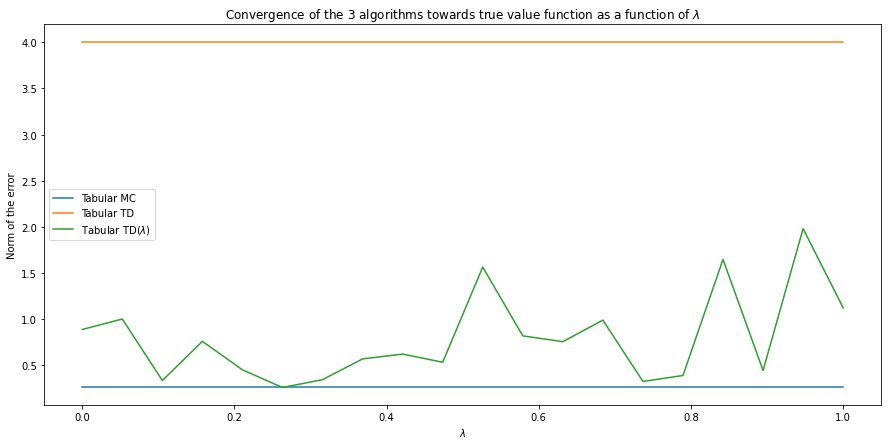

In [8]:
plt.plot(lambdas, [np.linalg.norm(mc_vf - true_vf)] * len(lambdas), label='Tabular MC')
plt.plot(lambdas, [np.linalg.norm(td_vf - true_vf)] * len(lambdas), label='Tabular TD')
plt.plot(lambdas, td_errors, label='Tabular TD$(\lambda)$')

plt.xlabel("$\lambda$")
plt.ylabel("Norm of the error")
plt.title("Convergence of the 3 algorithms towards true value function as a function of $\lambda$")
plt.legend()
plt.show()